In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
include("/home/javier/Desktop/alpcahus/alpcahus.jl")
include("/home/javier/Desktop/alpcahus/cluster.jl")
include("/home/javier/Desktop/alpcahus/otherMethods.jl")
include("/home/javier/Desktop/alpcahus/adssc.jl")

lsr (generic function with 1 method)

In [2]:
Y1 = load("astroData_z2_bal.jld","Yfull")
Y2 = load("astroData_z1.jld", "Yfull");
Y2 = Y2[:,randperm(size(Y2)[2])[1:2500]];
Y1 = Y1[51:281-50,randperm(size(Y1)[2])[1:2500]];
K = 2;

In [63]:
# Y1 = load("astroData_z2_bal.jld","Yfull")
# Y2 = load("astroData_z2.jld", "Yfull");
# Y2 = Y2[51:281-50,randperm(size(Y2)[2])[1:5000]];
# Y1 = Y1[:,randperm(size(Y1)[2])[1:5000]];
# K = 2;

In [3]:
#Y1s = Y1[:, randperm(5000)[1:10]]
Y = hcat(Y1,Y2);
C = vcat(ones(2500), 2*ones(2500));

In [4]:
U = []
for k=1:K
    push!(U,fastALPCAH(Y[:,C .== k], 5; varfloor=1e-9, alpcahIter= 100, fastCompute=false))
end
C_oracle = clusterAssignment(Y, U, K);
clusterError(C,C_oracle)

3.36

In [5]:
trainSize = 200
Ytest = hcat(Y1[:,randperm(2500)[1:trainSize]], Y2[:,randperm(2500)[1:trainSize]]);
Ctest = vcat(ones(trainSize), 2*ones(trainSize));

In [145]:
C_ekss = ALPCAHUS(Ytest,K,[3;3]; B=64, q=20, T=3, subspaceMethod=:pca, finalStep=false)
clusterError(Ctest,C_ekss)

29.75

In [146]:
# alpcahus trail
C_alpcahus = ALPCAHUS(Ytest,K,[3;3]; B=64, q=20, T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true) 
clusterError(Ctest,C_alpcahus)

3.25

In [147]:
# ekss smart init trial
C_kss = ALPCAHUS(Ytest, K, [3;3]; B=1, q=20, T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
clusterError(Ctest, C_kss)

6.25

In [148]:
# alpcahus smart init trail
C_alpcah = ALPCAHUS(Ytest,K, [3;3]; B=1, q=20, T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true)
clusterError(Ctest, C_alpcah)

2.75

In [176]:
C_adssc = adsscWrapper(Ytest, 5000,0.1; K=2)
clusterError(Ctest, C_adssc)

12.5

In [165]:
# tsc
C_tsc = tscWrapper(Ytest, 10; K=2)
clusterError(Ctest,C_tsc)

10.5

In [173]:
# kmeans
C_kmeans = kmeans(Elkan(), Ytest, 2; k_init="k-means++").assignments
clusterError(Ctest,C_kmeans)

49.75

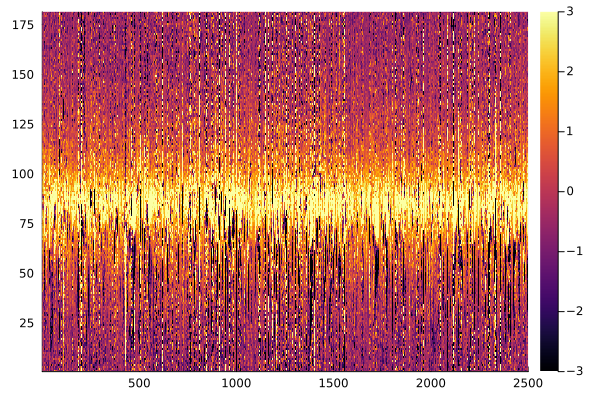

In [151]:
heatmap(Y1, clim=(-3,3))

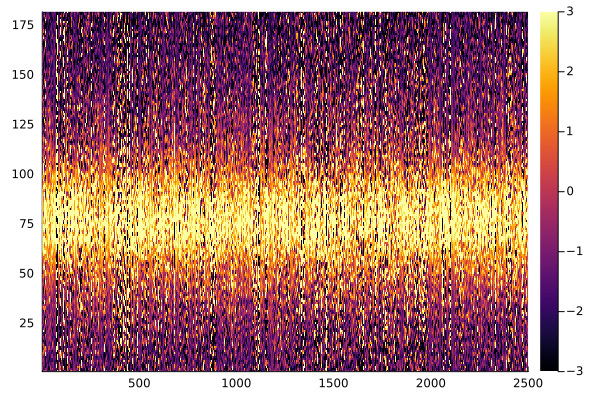

In [152]:
heatmap(Y2, clim=(-3,3))

In [10]:
include("../hemppcatFunctions.jl")

function hemppcatWrapperTSC(X::Matrix,K::Int,d::Int)
    D,N = size(X)
    c = tscWrapper(X, 10; K=K)
    
    T1 = svd(X[:,c .== 1])
    T2 = svd(X[:,c .== 2])
    F1 = T1.U[:,1:d]*Diagonal(sqrt.(T1.S[1:d]))
    F2 = T2.U[:,1:d]*Diagonal(sqrt.(T2.S[1:d]))
    
    F_init = [F1 , F2] # Factor matrices
    μ_init = zeros(D, K) # Mixture means
    π_init = [0.5, 0.5] # Mixing proportions
    
    v_init = ones(N)
    n = ones(Int,N) # number of points in each variance group
    
    # Mixture HEPPCAT
    model = create_HeMPPCATModel(F_init, μ_init, π_init, v_init, n) # Initialize a HeMPPCATModel object
    Y = [c[:] for c in eachcol(X)]
    results, _ = hemppcat(model, Y; eps=1e-6); # Run HeMPPCAT
    
    U1 = svd(results.F[1]).U
    U2 = svd(results.F[2]).U
    labelsHEMPPCAT = clusterAssignment(X, [U1,U2], K)
    
    return labelsHEMPPCAT
end

C_hemppcat = hemppcatWrapperTSC(Ytest,2,3)
clusterError(Ctest,C_hemppcat)

LoadError: MethodError: no method matching diag(::Float64)

[0mClosest candidates are:
[0m  diag([91m::Symmetric[39m)
[0m[90m   @[39m [32mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.9.3+0.x64.linux.gnu/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4msymmetric.jl:241[24m[39m
[0m  diag([91m::FillArrays.RectDiagonal[39m)
[0m[90m   @[39m [33mFillArrays[39m [90m~/.julia/packages/FillArrays/KpKaA/src/[39m[90m[4mFillArrays.jl:354[24m[39m
[0m  diag([91m::Hermitian[39m)
[0m[90m   @[39m [32mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.9.3+0.x64.linux.gnu/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4msymmetric.jl:242[24m[39m
[0m  ...
